# Credits

The code in this notebook was based on the tutorials provided by [Maxim Labonne](https://mlabonne.github.io/blog/about.html) and Ms. Jazzie Jao.

Specifically these set of tutorials:
- [Graph Convolutional Networks](https://mlabonne.github.io/blog/posts/2022_02_20_Graph_Convolution_Network.html)
- [Graph Attention Networks](https://mlabonne.github.io/blog/posts/2022-03-09-Graph_Attention_Network.html)
- [GraphSAGE](https://mlabonne.github.io/blog/posts/2022-04-06-GraphSAGE.html)
- Tutorial provided by Ms. Jao

# Libraries Used

**Note** this was coded in Google Colab. It is recommended that you run this in Colab.

**Warning** due to dependencies, we have **downgraded** **torch** to 2.5.1.

In [1]:
version = '2.5.1+cu124'

!pip install torch==2.5.1 --index-url https://download.pytorch.org/whl/cu124

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{version}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{version}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{version}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pyg-lib -f https://data.pyg.org/whl/torch-{version}.html

Looking in indexes: https://download.pytorch.org/whl/cu124
Found existing installation: torch_scatter 2.1.2+pt25cu124
Uninstalling torch_scatter-2.1.2+pt25cu124:
  Successfully uninstalled torch_scatter-2.1.2+pt25cu124
Found existing installation: torch_sparse 0.6.18+pt25cu124
Uninstalling torch_sparse-0.6.18+pt25cu124:
  Successfully uninstalled torch_sparse-0.6.18+pt25cu124
Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
Found existing installation: torch_cluster 1.6.3+pt25cu124
Uninstalling torch_cluster-1.6.3+pt25cu124:
  Successfully uninstalled torch_cluster-1.6.3+pt25cu124
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/torch_scatter-2.1.2%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (10.8 MB)
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/to

In [2]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch.nn import Linear
from torch_geometric.utils import to_dense_adj, to_networkx

from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv
import torch.nn.functional as F

from torch_geometric.loader import NeighborLoader

import time

from sklearn.decomposition import PCA

# Dataset

The dataset that we will be using is the Pubmed dataset.

The dataset consists of 19,717 nodes. These nodes represent a publication about diabetes.

Each node has 500 features where each represent a weighted word vector [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [3]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Pubmed")
data = dataset[0]

print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of nodes: 19717
Number of features: 500
Number of classes: 3


# Our Problem

Our problem now is to identify what diabetes type is the topic in each paper. There are 3 types of diabetes, thus 3 classes.

We can do that by training a model to identify what type is that particular paper (represented as a node). This is essentially node classification.

# Graph Representation

Let us look into how the given dataset graph is represented

In [4]:
data = dataset[0]
print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


The collection of nodes with Graph Neural Networks are often represented as a node feature matrix, where each row represents a node while each column represents a feature. This is why the `x` variable in `data` has 19717 rows and 500 columns.

`y` represents the ground truth or the label of each node.

`train_mask`, `val_mask`, and `test_mask` is an array or `true` and false` this is used to identify which nodes are used for training, validation, and testing.



## Edge representation

The edges `edge_index` are represented as a coordinate list.

It is a 2 by `x` where `x` represents the number of edges the graph has.

The first row represents the starting connection. The second row represents the end connection.

Each column represents an edge connection.

### Example
We have a small given `edge_index` of 2x3, meaning we have 3 number of edges
```
[[1, 2, 3],
[1, 1, 2]]
```
From this, we can see that node 1 is connected with node 1, node 2 is connected with node 1, node 3 is connected with node 2.

Now let's see the `edge_index` of our graph

In [5]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


# Operations of Graph Neural Networks

1. Aggregate information from neighbor nodes
2. With the transformed nodes, apply a learnable function (such as Multilayer perceptrons) to each node.



# Type of Graph Neural Networks
For now, we have 3 popular types of Graph Neural Networks (GNN)
1. Graph Convolutional Network
2. Graph Attention Network
3. GraphSAGE

Each type of GNN has their pros and cons.

In this notebook, we will see the difference between these GNNs.

# Graph Convolutional Network


This section provides a comprehensive guide to understanding and implementing Graph Convolutional Networks (GCNs) using the PyTorch Geometric library.

This is the simplest architecture out of all the GNNs avaialble. Essentially what we do is add all the vectors of the neighboring nodes.

The Graph Convolution operation aggregates information from a node's neighbors:

$h_i = \sum_{j \in \tilde{\mathcal{N}}_i} \dfrac{1}{\sqrt{deg(i)} \sqrt{deg(j)}} W x_j$

Where:

- $\tilde{\mathcal{N}}$ represents the set of neighbors of node `i`
- $deg(i)$ represent the number of neighbors node `i` has
- $deg(j)$ represents the number of neighbor's neighbor.
- $h_i$ represents the output for node `i`
- $W$ is a learnable weight matrix

This formula normalizes neighbor information and applies a shared weight matrix.

- $\frac{1}{deg(i)}$ normalizes a node with a lot of neighbors. Since we are adding all vectors of all neighbors, the more neighbors a node has, the higher the value. Without this normalization, some nodes would have a higher value, making an imbalanced data set.
- $\frac{1}{deg(j)}$ normalizes a neighbor. From a [study](https://arxiv.org/abs/1609.02907) by Kipf et al. (2016), a node with a lot of neighbors propagates much more easily. Without control, this can lead to imbalanced data.

## Implementation

In python, the GNN models can be represented as a class.

Each class can have 3 functions:
- Initialization
- Feed forward
- Fitting

### Initialization
The main focus of initialization is to setup what type of layers that you may have and the optimizer algorithm of your choosing.

```python
def __init__(self, dim_in, dim_h, dim_out):
  super().__init__()
  self.gcn1 = GCNConv(dim_in, dim_h)
  self.gcn2 = GCNConv(dim_h, dim_out)
  self.optimizer = torch.optim.Adam(self.parameters(),
                                    lr=0.01,
                                    weight_decay=5e-4)
```

Where `dim_in` represent the dimension of the input, `dim_h` represent the number of nodes in each hidden layer, `dim_out` represent the dimension of the output layer which in this case is 7 since we are trying to classify a node which of the 7 paper type it is.

For this notebook, we will be using the Adam optimizer. This optimizer is out of scope of this lecture. But essentially, this optimizer adjusts the learning weight for each iteration for faster learning while avoiding overshooting.

### Feed Forward
Feed forward would be the whole structure on how the node embedding is inputted and outputted.

```python
def forward(self, x, edge_index):
  h = F.dropout(x, p=0.5, training=self.training)
  h = self.gcn1(h, edge_index).relu()
  h = F.dropout(h, p=0.5, training=self.training)
  h = self.gcn2(h, edge_index)
  return F.log_softmax(h, dim=1)
```

For this implementation, we will be using 2 layers and 1 output layer. The output is then fed into a softmax function.

We chose to do a dropout (not pass any data) 50% so that the model can be more generalizable to other unseen data. This is only done during training (when training flag is set to true)

Visually, we have this pipeline
![](https://drive.usercontent.google.com/download?id=1wGLl4BXO85rZqX9snpnR1NYK32DdwxLe&export=view&authuser=1)

Where ***W*** represents the weight being used in all connections under it.

### Fitting (optimizing weights)
To optimize the weights W in our graph convolutional network, we employ the Adam optimizer. Since this is a multiclass problem, we will use Cross Entropy Loss as our loss function.

```python
def fit(self, data, epochs):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = self.optimizer

  self.train()
  for epoch in range(epochs+1):
      # Training
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1),
                      data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      # Validation
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                          data.y[data.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                f'Val Acc: {val_acc*100:.2f}%')
```

`loss.backward()` computes the gradients based on the loss function and `optimizer.step()` uses these gradients to optimize the weights of the model.

For every epoch, the loss and accuracy is recorded. The validation and training set is being used for this.

For better understanding, we will print the results of the model every 10 epochs.

### Final model

We incorporate the final model with the code below

In [6]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

## Testing of model

### Metrics for testing

We will be measurin 2 metrics for our model
- Accuracy
- Training Time

Accuracy tells us how good our model is with solving the problem. Training time tells us how fast can we train the model.

Training time is important since we want to know if a model is *scalable*. If a model's training time raises fast, then it would take a lot of time for it to train on new data.

To test our model for acccuracy the function below for meassuring accuracy

In [7]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval() # sets the model into eval mode
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# We will use %%time to measure execution time.

### Training and testing results

We will now see how the model improves through training and the training time.

We will use 50 epochs to train the model.

We will collect the results of the trained model 5 times and average the running time and accuracy for the test set. This is so the results are more rigorous.

In [8]:
training_times = []
testing_accuracies =[]

for i in range(5):
  print(f"{i}'th iteration of training and testing")

  gcn = GCN(dataset.num_features, 64, dataset.num_classes)
  if i == 0:
    print(gcn)
  start_time = time.time()  # Start timer of training
  # Train
  gcn.fit(data, 50)
  end_time = time.time()  # End timer of training
  training_times.append(end_time - start_time)

  print(f'\nGCN training time: {end_time - start_time} seconds')
  print(f'GCN test accuracy: {test(gcn, data)*100:.2f}%\n')
  testing_accuracies.append(test(gcn, data)*100)

average_time = sum(training_times) / len(training_times)
average_accuracy = sum(testing_accuracies) / len(testing_accuracies)

print(f'Average training time: {average_time:.2f} seconds')
print(f'Average test accuracy: {average_accuracy:.2f}%')

0'th iteration of training and testing
GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.099 | Train Acc:  26.67% | Val Loss: 1.10 | Val Acc: 30.20%
Epoch  10 | Train Loss: 0.745 | Train Acc:  93.33% | Val Loss: 0.88 | Val Acc: 73.40%
Epoch  20 | Train Loss: 0.393 | Train Acc:  91.67% | Val Loss: 0.68 | Val Acc: 74.40%
Epoch  30 | Train Loss: 0.207 | Train Acc:  98.33% | Val Loss: 0.61 | Val Acc: 74.40%
Epoch  40 | Train Loss: 0.120 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 76.40%
Epoch  50 | Train Loss: 0.091 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 78.80%

GCN training time: 20.149057388305664 seconds
GCN test accuracy: 78.90%

1'th iteration of training and testing
Epoch   0 | Train Loss: 1.100 | Train Acc:  28.33% | Val Loss: 1.10 | Val Acc: 29.80%
Epoch  10 | Train Loss: 0.736 | Train Acc:  93.33% | Val Loss: 0.88 | Val Acc: 73.60%
Epoch  20 | Train Loss: 0.409 | Train Acc:  93.33% | Val Loss: 0.67 | Val Acc: 73.80%
Epoch  30 | Tra

We will record all values of all models for later's synthesis

In [9]:
all_results = {
    "GCN" : {
        "Training Time": average_time,
        "Test Accuracy": average_accuracy
    }
}

#Graph Attention Network

Graph Attention Networks (GAT) works similarly with GCN. The decerning factor is that when it is time for aggregating, the neighbors of a node don't have equal importance.

Some neigbors of a node may be more relevant than other neighbors. We call this relevance as *attention*. Attention is a weight that is multiplied to a tensor to scale its value.

How do we then compute the attention?

*Linear Transformation*

$a_{ij} = W^t_{att}[Wx_i || Wx_j]$

For each node, we have a learnable attention weight $W^t_{att}$. This is multiplied with the concatention of the dot product between a fixed weight matrix $W$ and the node i vector and neighbor node j vector.

*Pass it through an activation function*

To add non linearlity, we will pass the linear transformation into a nonlinear function

$e_{ij} = LeakyReLU(a_{ij})$

*Repeat the computation of $e$ for all neighbors*

${\forall}k(e_{ik} = LeakyReLU(a_{ij})| k \in \tilde{\mathcal{N}}_i)$

We then pass it through a softmax function to get the attention distribution of the neighbors for node i

Attention between node i and j:

$\alpha_{ij} = softmax(e_{ij})$

There can also be multiple attentions computed (multiple attention heads). This is so that the model can more robust and can be more stable. This multiple attention is calcualted with different attention weights $W^t_{att}$. All the computed attentions are multiplied to the respective neighbors creating a *variant* for each neighbor. All variants of a neighbor are concatenated together and averged on the output layer.


## Implementation

This has a similar implementation to GCNs. The only difference is the model that we use.

For our implementation, we would be using 8 attention heads.

```python
def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)
```
Instead of using the `GCNConv` class, we use the `GATv2Conv` class.

From the earlier's illustration, we now have an additional weight $\alpha$ that tells us how important that neightbor is.

![](https://drive.usercontent.google.com/download?id=1t4XZKJH7R_bBfaJ9aPx9-_PF8zZx3R-0&export=view&authuser=1)

Where ***W*** represents all the weights under it while **$\alpha$** represents the attention coefficent being multiplied to the respective neighbors of node i.

In [10]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

## Training and testing of model

In [11]:
training_times = []
testing_accuracies =[]

for i in range(5):
  print(f"{i}'th iteration of training and testing")

  gat = GAT(dataset.num_features, 64, dataset.num_classes)
  if i == 0:
    print(GAT)

  start_time = time.time()  # Start timer of training
  # Train
  gat.fit(data, 50)
  end_time = time.time()  # End timer of training
  training_times.append(end_time - start_time)

  print(f'\nGCN training time: {end_time - start_time} seconds')
  print(f'GCN test accuracy: {test(gat, data)*100:.2f}%\n')
  testing_accuracies.append(test(gat, data)*100)

average_time = sum(training_times) / len(training_times)
average_accuracy = sum(testing_accuracies) / len(testing_accuracies)

print(f'Average training time: {average_time:.2f} seconds')
print(f'Average test accuracy: {average_accuracy:.2f}%')

0'th iteration of training and testing
<class '__main__.GAT'>
Epoch   0 | Train Loss: 3.197 | Train Acc:   0.00% | Val Loss: 3.19 | Val Acc: 0.40%
Epoch  10 | Train Loss: 0.967 | Train Acc:  90.00% | Val Loss: 1.05 | Val Acc: 67.20%
Epoch  20 | Train Loss: 0.577 | Train Acc:  91.67% | Val Loss: 0.78 | Val Acc: 73.00%
Epoch  30 | Train Loss: 0.330 | Train Acc:  95.00% | Val Loss: 0.62 | Val Acc: 76.20%
Epoch  40 | Train Loss: 0.167 | Train Acc:  96.67% | Val Loss: 0.57 | Val Acc: 77.80%
Epoch  50 | Train Loss: 0.096 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.40%

GCN training time: 213.2979485988617 seconds
GCN test accuracy: 77.70%

1'th iteration of training and testing
Epoch   0 | Train Loss: 3.168 | Train Acc:   3.33% | Val Loss: 3.17 | Val Acc: 2.00%
Epoch  10 | Train Loss: 0.917 | Train Acc:  85.00% | Val Loss: 0.99 | Val Acc: 70.40%
Epoch  20 | Train Loss: 0.525 | Train Acc:  91.67% | Val Loss: 0.74 | Val Acc: 74.40%
Epoch  30 | Train Loss: 0.253 | Train Acc:  95.00% | V

We can see that it took significantly more time to train the graph attention network. This is because aside from optimizing the weights of the network, we also optimize the weights for the computation of all *attention* in the graph.

We can also see that the accuracy of both GCN and GAT is not far from each other. But, the training time of GAT is significantly higher.

This does not mean that GATs are inferior. It just means that this would not be the right dataset to use a GAT. Since GAT stores additional information through attention, we can say that this is a much more powerful model. We can see the benefits of using GAT with much more complex datasets.

In [12]:
all_results["GAT"] = {
    "Training Time": average_time,
    "Test Accuracy": average_accuracy
}

# GraphSAGE

GraphSAGE employs a similar aggregation strategy with all the GNN architectures. What it does differntly is sampling.

With GCN and GATs we aggregate all the node's neighbor. This can be a problem since when the graph has a lot of nodes, the computational cost rapidly rises.

The first objective of GraphSAGE is to reduce the number of nodes through sampling without too much compromise of the accuracy of the model.

This is the algorithm for sampling
```
For each seed node:
  Choose j number of neighbors randomly
    For every neighbor
      choose k number of neighbors randomly
        ...
    Drop unchosen neighbors
  Drop unchosen neighbors
```
We can choose to have as many hop neighbors as we want, but for our implementation we would use `[5, 10]`. Meaning we would choose 5 neighbors and 10 neigbors for each of those 5 neighbors. The starting node is called seed node.

For better efficiency, we can also split the whole graph into subgraphs. We can do this by creating batches. This is where batch size matters. Batch size tells us how many number of seed nodes would be used per batch. For example if we have 20 nodes and a batch size of 10, we would have 2 subgraphs. Each subgrpah contains 10 seed nodes and their corresponding sampled neighbors.

In [13]:
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[401, 500], edge_index=[2, 450], y=[401], train_mask=[401], val_mask=[401], test_mask=[401], n_id=[401], e_id=[450], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[261, 500], edge_index=[2, 309], y=[261], train_mask=[261], val_mask=[261], test_mask=[261], n_id=[261], e_id=[309], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 324], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], n_id=[289], e_id=[324], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[197, 500], edge_index=[2, 228], y=[197], train_mask=[197], val_mask=[197], test_mask=[197], n_id=[197], e_id=[228], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[12], batch_size=12)


Now that subgraphs are avaialble, all seed nodes in the subgraph will be aggregated with their neighbors.

For GraphSAGE, there are currenlty 3 ways to aggregate.
1. Mean aggregator: All neighbor nodes are averaged and then multiplied to a weight.
2. LSTM: Each neighbor is fed through an LSTM to produce a final vector. Since there is not sequence between the neighbors, the neighbros are fed randomly through the LSTM.
3. Pooling: All neighbors are passed through a neural network and then the max element out of all the vectors is recorded.

Out of all the aggregators, LSTM is the most accurate one. But the mean is the most easy to implement. For this notebook, we will only use the mean aggreagator which has this formula

$h_i = W \cdot mean_{j\in\tilde{\mathcal{N}}}(h_{ij})$

## Implementation

We first need to setup the batches in the model's initialization

```python
def __init__(self, dim_in, dim_h, dim_out, data):
  super().__init__()
  self.sage1 = SAGEConv(dim_in, dim_h)
  self.sage2 = SAGEConv(dim_h, dim_out)
  self.optimizer = torch.optim.Adam(self.parameters(),
                                    lr=0.01,
                                    weight_decay=5e-4)
  self.train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
  )
```

The forward method is the same structure used with GCNs and GAT

For the fitting, since we have batches (subgraphs), we iterate through all of them. For each subgraph, we optimize the weights of the model

```python
def fit(self, data, epochs):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = self.optimizer

  self.train()
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Train on batches
    for batch in train_loader:
      optimizer.zero_grad()
      out = self(batch.x, batch.edge_index)
      loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
      total_loss += loss
      acc += accuracy(out[batch.train_mask].argmax(dim=1),
                      batch.y[batch.train_mask])
      loss.backward()
      optimizer.step()

      # Validation
      val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
      val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                          batch.y[batch.val_mask])
```

Below, we have the full implementation of GraphSage

In [14]:
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out, data):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    self.train_loader = NeighborLoader(
      data,
      num_neighbors=[5, 10],
      batch_size=16,
      input_nodes=data.train_mask,
    )

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

## Training and testing of model

In [15]:
training_times = []
testing_accuracies =[]

for i in range(5):
  print(f"{i}'th iteration of training and testing")

  graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes, data)
  if i == 0:
    print(graphsage)

  start_time = time.time()  # Start timer of training
  # Train
  graphsage.fit(data, 50)
  end_time = time.time()  # End timer of training
  training_times.append(end_time - start_time)

  print(f'\nGCN training time: {end_time - start_time} seconds')
  print(f'GCN test accuracy: {test(graphsage, data)*100:.2f}%\n')
  testing_accuracies.append(test(graphsage, data)*100)

average_time = sum(training_times) / len(training_times)
average_accuracy = sum(testing_accuracies) / len(testing_accuracies)

print(f'Average training time: {average_time:.2f} seconds')
print(f'Average test accuracy: {average_accuracy:.2f}%')

0'th iteration of training and testing
GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.140 | Train Acc:  30.08% | Val Loss: 1.12 | Val Acc: 30.97%
Epoch  10 | Train Loss: 0.096 | Train Acc:  98.53% | Val Loss: 0.68 | Val Acc: 64.12%
Epoch  20 | Train Loss: 0.030 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 74.38%
Epoch  30 | Train Loss: 0.044 | Train Acc:  98.61% | Val Loss: 0.65 | Val Acc: 67.68%
Epoch  40 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 73.13%
Epoch  50 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 78.47%

GCN training time: 1.378309965133667 seconds
GCN test accuracy: 76.80%

1'th iteration of training and testing
Epoch   0 | Train Loss: 1.133 | Train Acc:  29.56% | Val Loss: 1.09 | Val Acc: 39.17%
Epoch  10 | Train Loss: 0.080 | Train Acc: 100.00% | Val Loss: 0.68 | Val Acc: 76.25%
Epoch  20 | Train Loss: 0.026 | Train Acc: 100.00% | Val Loss: 0.68 | 

The training time of GraphSAGE took significantly less amount of time compated to GCN and GAT.

Even though this has the lowest accuracy among the 3, one should also put importance on scalability. GraphSAGE is by far the most scalable model since it can already have good results just by sampling data.

In [16]:
all_results['GraphSAGE'] = {
    "Training Time": average_time,
    "Test Accuracy": average_accuracy
}

# Results

In [17]:
# Print table header
print(f"{'Architecture':<15} | {'Average Time':>15} | {'Average Accuracy':>15}")
print("-" * 42)

# Print data rows
for model, metrics in all_results.items():
    print(f"{model:<15} | {metrics['Training Time']:>15.2f} | {metrics['Test Accuracy']:>15.2f}")

Architecture    |    Average Time | Average Accuracy
------------------------------------------
GCN             |           14.57 |           78.54
GAT             |          215.18 |           77.04
GraphSAGE       |            1.47 |           76.90


We can see that GCN has the highest accuracy of them all.

Even though GAT is the most resource intensive, it did not have the highest accuracy score. This can be because the data that we have was not complex enough to reap the benefits of GAT.

We can also see that GraphSAGE is the fastest. This is because we have only sampled the nodes and edges. Even though it's accuracy is inferior, this architecture is the most scalable.

With the code below, we will visually see how the 3 models were able to arrange the datapoints.

With this visual, we can compare how each of the model succesfully distinguish each datapoint from each other.

In [26]:
from sklearn.metrics import pairwise_distances
import numpy as np

def visualize_latent_space(model, data):
    """
    Visualizes the latent space of a GNN model using PCA and calculates clustering metrics.

    Parameters:
    -----------
    model : torch.nn.Module
        A graph neural network model (GCN, GAT, or GraphSAGE)
    data : torch_geometric.data.Data
        The graph data object
    """
    model.eval()  # Set model to evaluation mode

    # Detect model type and extract latent representation accordingly
    with torch.no_grad():
        x, edge_index = data.x, data.edge_index

        # Common first step for all models: apply dropout to input
        h = F.dropout(x, p=0.5, training=False)

        # Extract intermediate representation based on model type
        if hasattr(model, 'gcn1'):  # GCN model
            h = model.gcn1(h, edge_index).relu()
            h = F.dropout(h, p=0.5, training=False)
            latent = model.gcn2(h, edge_index)
        elif hasattr(model, 'gat1'):  # GAT model
            h = model.gat1(h, edge_index).relu()
            h = F.dropout(h, p=0.5, training=False)
            latent = model.gat2(h, edge_index)
        elif hasattr(model, 'sage1'):  # GraphSAGE model
            h = model.sage1(h, edge_index).relu()
            h = F.dropout(h, p=0.5, training=False)
            latent = model.sage2(h, edge_index)
        else:
            raise TypeError("Unsupported model type. Must be GCN, GAT, or GraphSAGE")

        # Apply dimensionality reduction
        pca = PCA(n_components=2)
        latent_np = latent.cpu().numpy()
        reduced = pca.fit_transform(latent_np)

        # Prepare labels
        labels = data.y.cpu().numpy()

    # Calculate clustering metrics
    unique_labels = np.unique(labels)
    centroids = {}
    intra_dists = []
    inter_dists = []

    # Calculate intra-class distances
    for label in unique_labels:
        mask = labels == label
        class_points = reduced[mask]

        # Calculate centroid
        centroids[label] = np.mean(class_points, axis=0)

        # Calculate pairwise distances within class
        if len(class_points) > 1:
            dist_matrix = pairwise_distances(class_points)
            intra_dists.append(np.mean(dist_matrix[np.triu_indices(len(class_points), k=1)]))

    # Calculate inter-class distances (between centroids)
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            dist = np.linalg.norm(centroids[unique_labels[i]] - centroids[unique_labels[j]])
            inter_dists.append(dist)

    # Calculate metrics
    avg_intra = np.mean(intra_dists) if intra_dists else 0
    avg_inter = np.mean(inter_dists) if inter_dists else 0
    separation_ratio = avg_intra / avg_inter if avg_inter != 0 else float('inf')

    # Visualization
    num_classes = len(unique_labels)
    cmap = plt.get_cmap('tab10', num_classes)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        reduced[:, 0],
        reduced[:, 1],
        c=labels,
        cmap=cmap,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5,
        s=40
    )

    # Plot centroids
    for label, centroid in centroids.items():
        plt.scatter(centroid[0], centroid[1], marker='X', s=200,
                    edgecolors='black', linewidth=1.5,
                    c=[cmap(label)], label=f'Centroid {label}')

    # Determine model type for title
    model_type = "GNN"
    if hasattr(model, 'gcn1'):
        model_type = "GCN"
    elif hasattr(model, 'gat1'):
        model_type = "GAT"
    elif hasattr(model, 'sage1'):
        model_type = "GraphSAGE"

    # Create info box
    metrics_text = (
        f"Avg Intra-class Distance: {avg_intra:.2f}\n"
        f"Avg Inter-class Distance: {avg_inter:.2f}\n"
        f"Separation Ratio: {separation_ratio:.2f}"
    )

    plt.title(f'{model_type} Latent Space Visualization with Cluster Metrics')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Add metrics textbox
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(
                 boxstyle='round', facecolor='white', alpha=0.9))

    # Create legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=cmap(i), markersize=10,
                   label=f'Class {label}')
        for i, label in enumerate(unique_labels)
    ]
    plt.legend(handles=legend_elements, title="Classes",
               loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

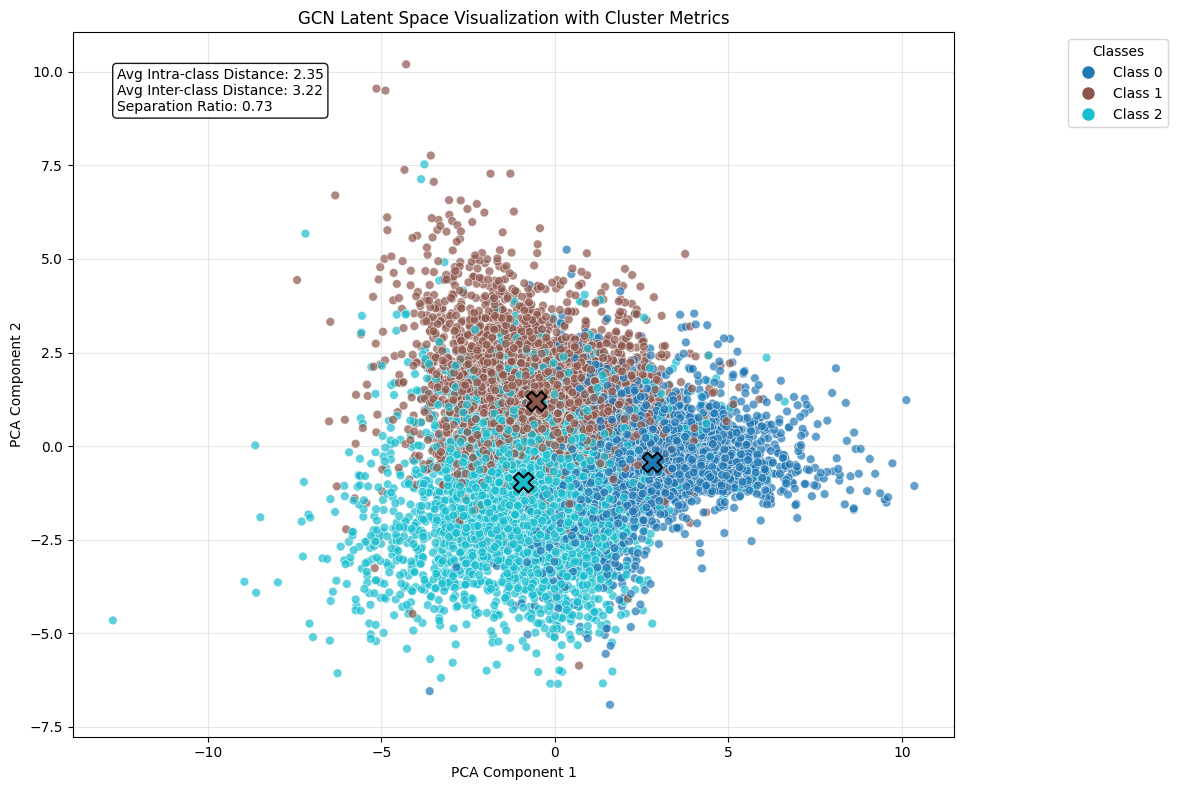

In [27]:
visualize_latent_space(gcn, data)

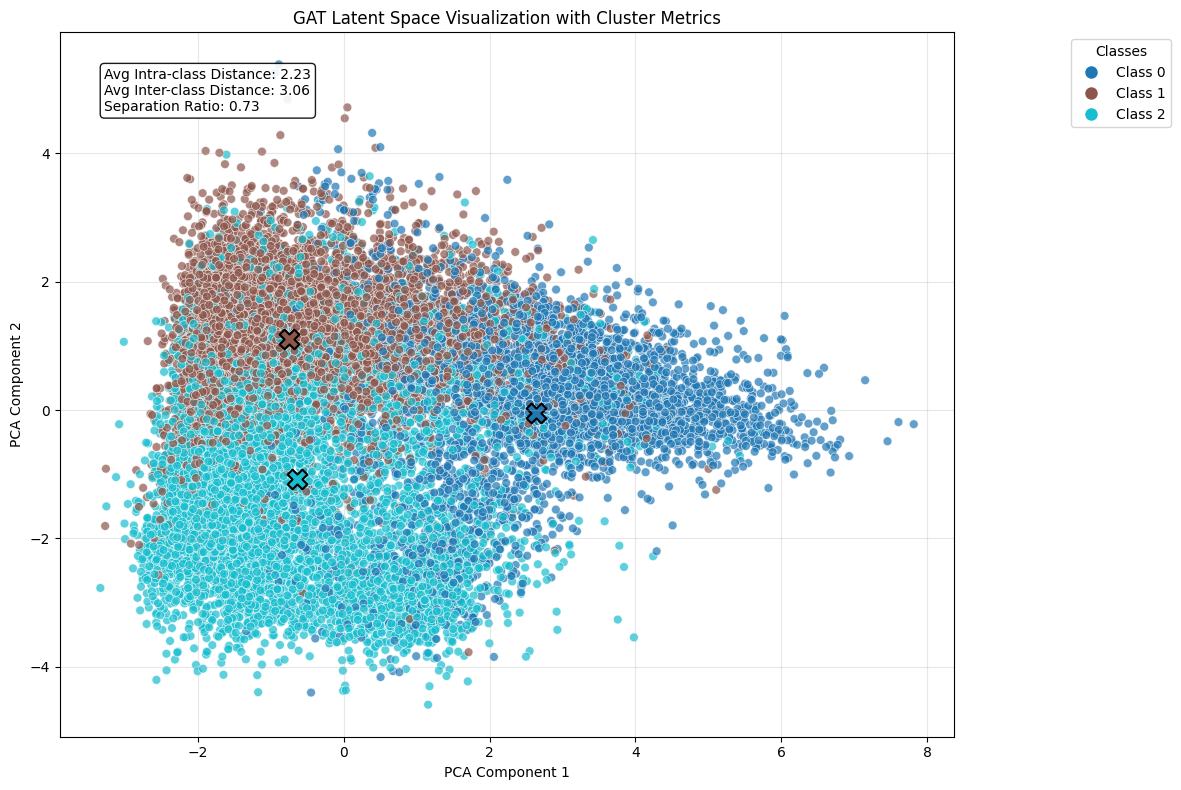

In [28]:
visualize_latent_space(gat, data)

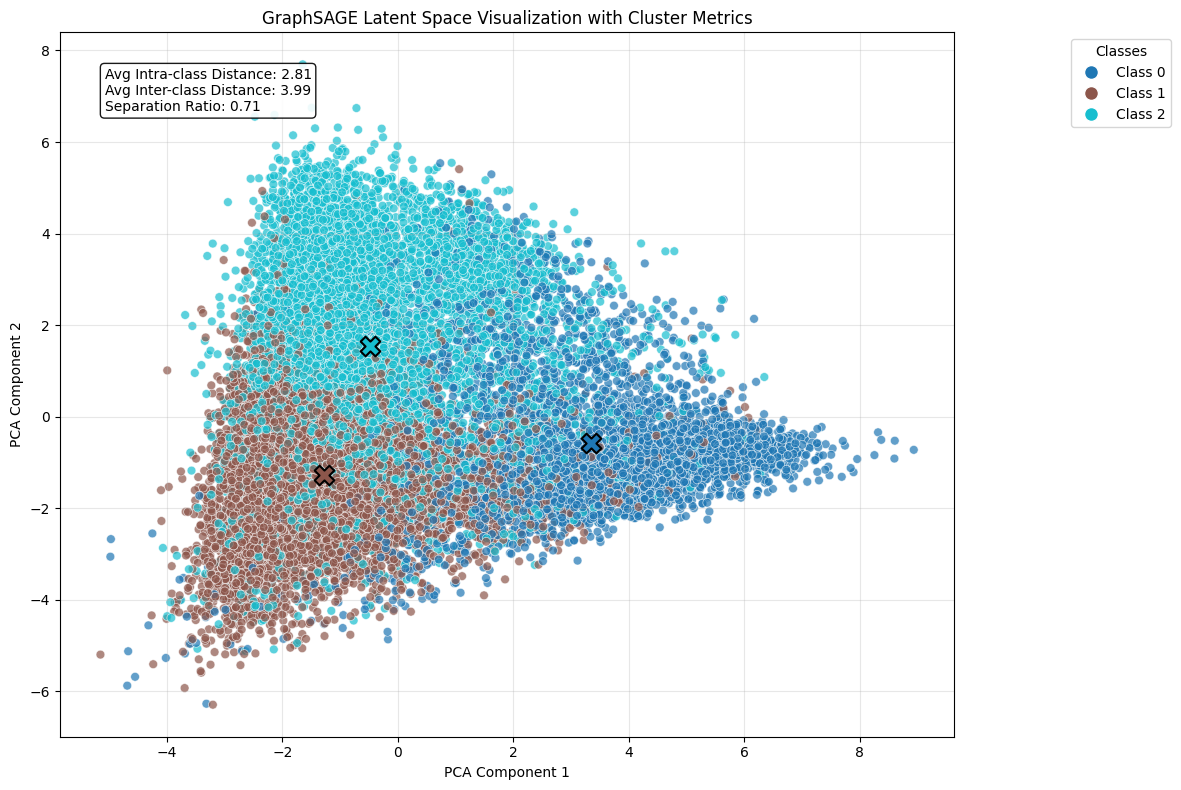

In [29]:
visualize_latent_space(graphsage, data)